<center><img src='https://raw.githubusercontent.com/Jangrae/img/master/ml_python.png' width=600/></center>

<img src = "https://github.com/Jangrae/img/blob/master/mobile2.png?raw=true" width=800 align="left"/>

# 실습 내용

- K-Fold Cross Validation을 사용해 모델의 성능을 예측합니다.

# 1.환경 준비

- 기본 라이브러리와 대상 데이터를 가져와 이후 과정을 준비합니다.

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format='retina'

In [2]:
# 데이터 읽어오기
path = 'https://raw.githubusercontent.com/Jangrae/csv/master/mobile_cust_churn.csv'
data = pd.read_csv(path)

# 2.데이터 이해

- 분석할 데이터를 충분히 이해할 수 있도록 다양한 탐색 과정을 수행합니다.

In [3]:
# 데이터 살펴보기
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,1,0,31953,0,6,313378,161,0,4,unsat,little,no,STAY
1,2,1,36147,0,13,800586,244,0,6,unsat,little,considering,STAY
2,3,1,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,STAY
3,4,0,120070,38,33,788235,780,3,2,unsat,very_high,considering,LEAVE
4,5,1,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,STAY


**데이터 설명**

- COLLEGE: 대학 졸업여부
- INCOME: 연수입
- OVERAGE: 월평균 초과사용 시간(분)
- LEFTOVER: 월평균 잔여시간비율(%)
- HOUSE: 집값
- HANDSET_PRICE: 스마트폰 가격
- OVER_15MINS_CALLS_PER_MONTH: 월평균 장기통화(15분이상) 횟수
- AVERAGE_CALL_DURATION: 평균 통화 시간
- REPORTED_SATISFACTION: 만족도 설문조사 결과
- REPORTED_USAGE_LEVEL: 사용도 자가진단 결과
- CONSIDERING_CHANGE_OF_PLAN: 향후 변경계획 설문조사 결과
- CHURN: 이탈(번호이동) 여부 (Target 변수)

In [4]:
# 기초통계정보 확인
data.describe()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,0.502400,80281.447750,85.979550,23.898650,493155.264250,389.615100,8.000700,6.002250
std,5773.647028,0.500007,41680.586319,85.992324,26.816645,252407.884692,213.820682,8.925418,4.402558
min,1.000000,0.000000,20007.000000,-2.000000,0.000000,150002.000000,130.000000,0.000000,1.000000
25%,5000.750000,0.000000,42217.000000,0.000000,0.000000,263714.250000,219.000000,1.000000,2.000000
50%,10000.500000,1.000000,75366.500000,59.000000,14.000000,452259.500000,326.000000,4.000000,5.000000
75%,15000.250000,1.000000,115881.750000,179.000000,41.000000,702378.000000,533.250000,15.000000,10.000000
max,20000.000000,1.000000,159983.000000,335.000000,89.000000,999996.000000,899.000000,29.000000,15.000000


# 3.데이터 준비

- 전처리 과정을 통해 머신러닝 알고리즘에 사용할 수 있는 형태의 데이터를 준비합니다.

**1) 변수 제거**

In [5]:
# 제거 대상: id


# 변수 제거
data.drop('id',axis=1, inplace=True)

# 확인
data.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,0,31953,0,6,313378,161,0,4,unsat,little,no,STAY
1,1,36147,0,13,800586,244,0,6,unsat,little,considering,STAY
2,1,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,STAY
3,0,120070,38,33,788235,780,3,2,unsat,very_high,considering,LEAVE
4,1,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,STAY


**2) x, y 분리**

In [6]:
# Target 설정
target = 'CHURN'

# 데이터 분리
X = data.drop(target,axis=1)
y = data[target]

**3) 가변수화**

In [7]:
# 가변수화 대상: 'REPORTED_SATISFACTION, REPORTED_USAGE_LEVEL, CONSIDERING_CHANGE_OF_PLAN]
dumm_cols = ['REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL', 'CONSIDERING_CHANGE_OF_PLAN']

# 가변수화
X = pd.get_dummies(X, columns=dumm_cols, drop_first=True)

# 확인
X.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION_sat,REPORTED_SATISFACTION_unsat,REPORTED_SATISFACTION_very_sat,REPORTED_SATISFACTION_very_unsat,REPORTED_USAGE_LEVEL_high,REPORTED_USAGE_LEVEL_little,REPORTED_USAGE_LEVEL_very_high,REPORTED_USAGE_LEVEL_very_little,CONSIDERING_CHANGE_OF_PLAN_considering,CONSIDERING_CHANGE_OF_PLAN_never_thought,CONSIDERING_CHANGE_OF_PLAN_no,CONSIDERING_CHANGE_OF_PLAN_perhaps
0,0,31953,0,6,313378,161,0,4,0,1,0,0,0,1,0,0,0,0,1,0
1,1,36147,0,13,800586,244,0,6,0,1,0,0,0,1,0,0,1,0,0,0
2,1,27273,230,0,305049,201,16,15,0,1,0,0,0,0,0,1,0,0,0,1
3,0,120070,38,33,788235,780,3,2,0,1,0,0,0,0,1,0,1,0,0,0
4,1,29215,208,85,224784,241,21,1,0,0,0,1,0,1,0,0,0,1,0,0


**3) 정규화**

In [9]:
# 정규화 대상: INCOME, OVERAGE, LEFTOVER, HOUSE, HANDSET_PRICE, OVER_15MINS_CALLS_PER_MONTH, AVERAGE_CALL_DURATION

# 정규화
X = (X - X.min()) / (X.max()-X.min())

# 확인
X

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION_sat,REPORTED_SATISFACTION_unsat,REPORTED_SATISFACTION_very_sat,REPORTED_SATISFACTION_very_unsat,REPORTED_USAGE_LEVEL_high,REPORTED_USAGE_LEVEL_little,REPORTED_USAGE_LEVEL_very_high,REPORTED_USAGE_LEVEL_very_little,CONSIDERING_CHANGE_OF_PLAN_considering,CONSIDERING_CHANGE_OF_PLAN_never_thought,CONSIDERING_CHANGE_OF_PLAN_no,CONSIDERING_CHANGE_OF_PLAN_perhaps
0,0.0,0.085343,0.005935,0.067416,0.192208,0.040312,0.000000,0.214286,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.115305,0.005935,0.146067,0.765398,0.148244,0.000000,0.357143,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.051909,0.688427,0.000000,0.182410,0.092328,0.551724,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.714858,0.118694,0.370787,0.750868,0.845254,0.103448,0.071429,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.065783,0.623145,0.955056,0.087979,0.144343,0.724138,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.0,0.951913,0.005935,0.258427,0.256944,0.607282,0.034483,0.357143,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,1.0,0.622385,0.216617,0.921348,0.102818,0.622887,0.172414,0.071429,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
19997,0.0,0.418086,0.005935,0.741573,0.026573,0.188557,0.000000,0.071429,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
19998,0.0,0.419122,0.145401,0.460674,0.496949,0.205462,0.137931,0.071429,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


**4) 학습용, 평가용 데이터 분리**

In [10]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split

# 7:3으로 분리
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=2022)

# 4.성능 예측

- K분할 교차 검증 방법으로 모델 성능을 예측합니다.
- cross_val_score(model, x_train, y_train, cv=n) 형태로 사용합니다.
- cv 옵션에 k값(분할 개수, 기본값=5)을 지정합니다.
- cross_val_score 함수는 넘파이 배열 형태의 값을 반환합니다.
- cross_val_score 함수 반환 값의 평균을 해당 모델의 예측 성능으로 볼 수 있습니다.

**1) KNN**

In [14]:
# 불러오기
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# 선언하기 
kn = KNeighborsClassifier()

# 검증하기
k_acc_score = cross_val_score(kn, X_train, y_train, cv=10)

# 확인
print(k_acc_score.mean())


0.6037857142857143


**2) Decision Tree**

In [27]:
# 불러오기
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


# 선언하기 
dt = DecisionTreeClassifier(max_depth=,random_state=2022)

# 검증하기
k_acc_score = cross_val_score(dt, X_train, y_train, cv=10)

# 확인

print(k_acc_score.mean())

0.6809285714285714


In [32]:
# 최적의 max_depth를 위한 반복문 돌리기
for i in range(1,15):
    dt = DecisionTreeClassifier(max_depth=i,random_state=2022)
    k_acc_score = cross_val_score(dt, X_train, y_train, cv=10)
    print(f'max_depth:{i}:',k_acc_score.mean())

max_depth:1: 0.6131428571428571
max_depth:2: 0.6532142857142857
max_depth:3: 0.6892142857142857
max_depth:4: 0.6984285714285713
max_depth:5: 0.6925
max_depth:6: 0.6919285714285713
max_depth:7: 0.6862142857142857
max_depth:8: 0.6837142857142856
max_depth:9: 0.6809285714285714
max_depth:10: 0.6745714285714286
max_depth:11: 0.6697142857142857
max_depth:12: 0.6639285714285714
max_depth:13: 0.6604285714285715
max_depth:14: 0.6525


**3) Logistic Regression**

In [22]:
# 불러오기
from sklearn.linear_model import LogisticRegression


# 선언하기 
lr = LogisticRegression(max_iter=1000)

# 검증하기
k_acc_score = cross_val_score(lr,X_train,y_train,cv=10)

# 확인
print(k_acc_score.mean())


0.6388571428571428


# 5) 성능 확인
- 가장 성능이 좋았던 LogisticRegression 모델을 데려와 최종 test를 해보자

In [34]:
# 1단계: 불러오기
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

# 2단계: 선언하기
dt = DecisionTreeClassifier(max_depth=4,random_state=2022)

# 3단계: 학습하기
dt.fit(X_train, y_train)

# 4단계: 예측하기
y_pred = dt.predict(X_test)

# 5단계 평가하기
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[2269  655]
 [1103 1973]]
              precision    recall  f1-score   support

       LEAVE       0.67      0.78      0.72      2924
        STAY       0.75      0.64      0.69      3076

    accuracy                           0.71      6000
   macro avg       0.71      0.71      0.71      6000
weighted avg       0.71      0.71      0.71      6000



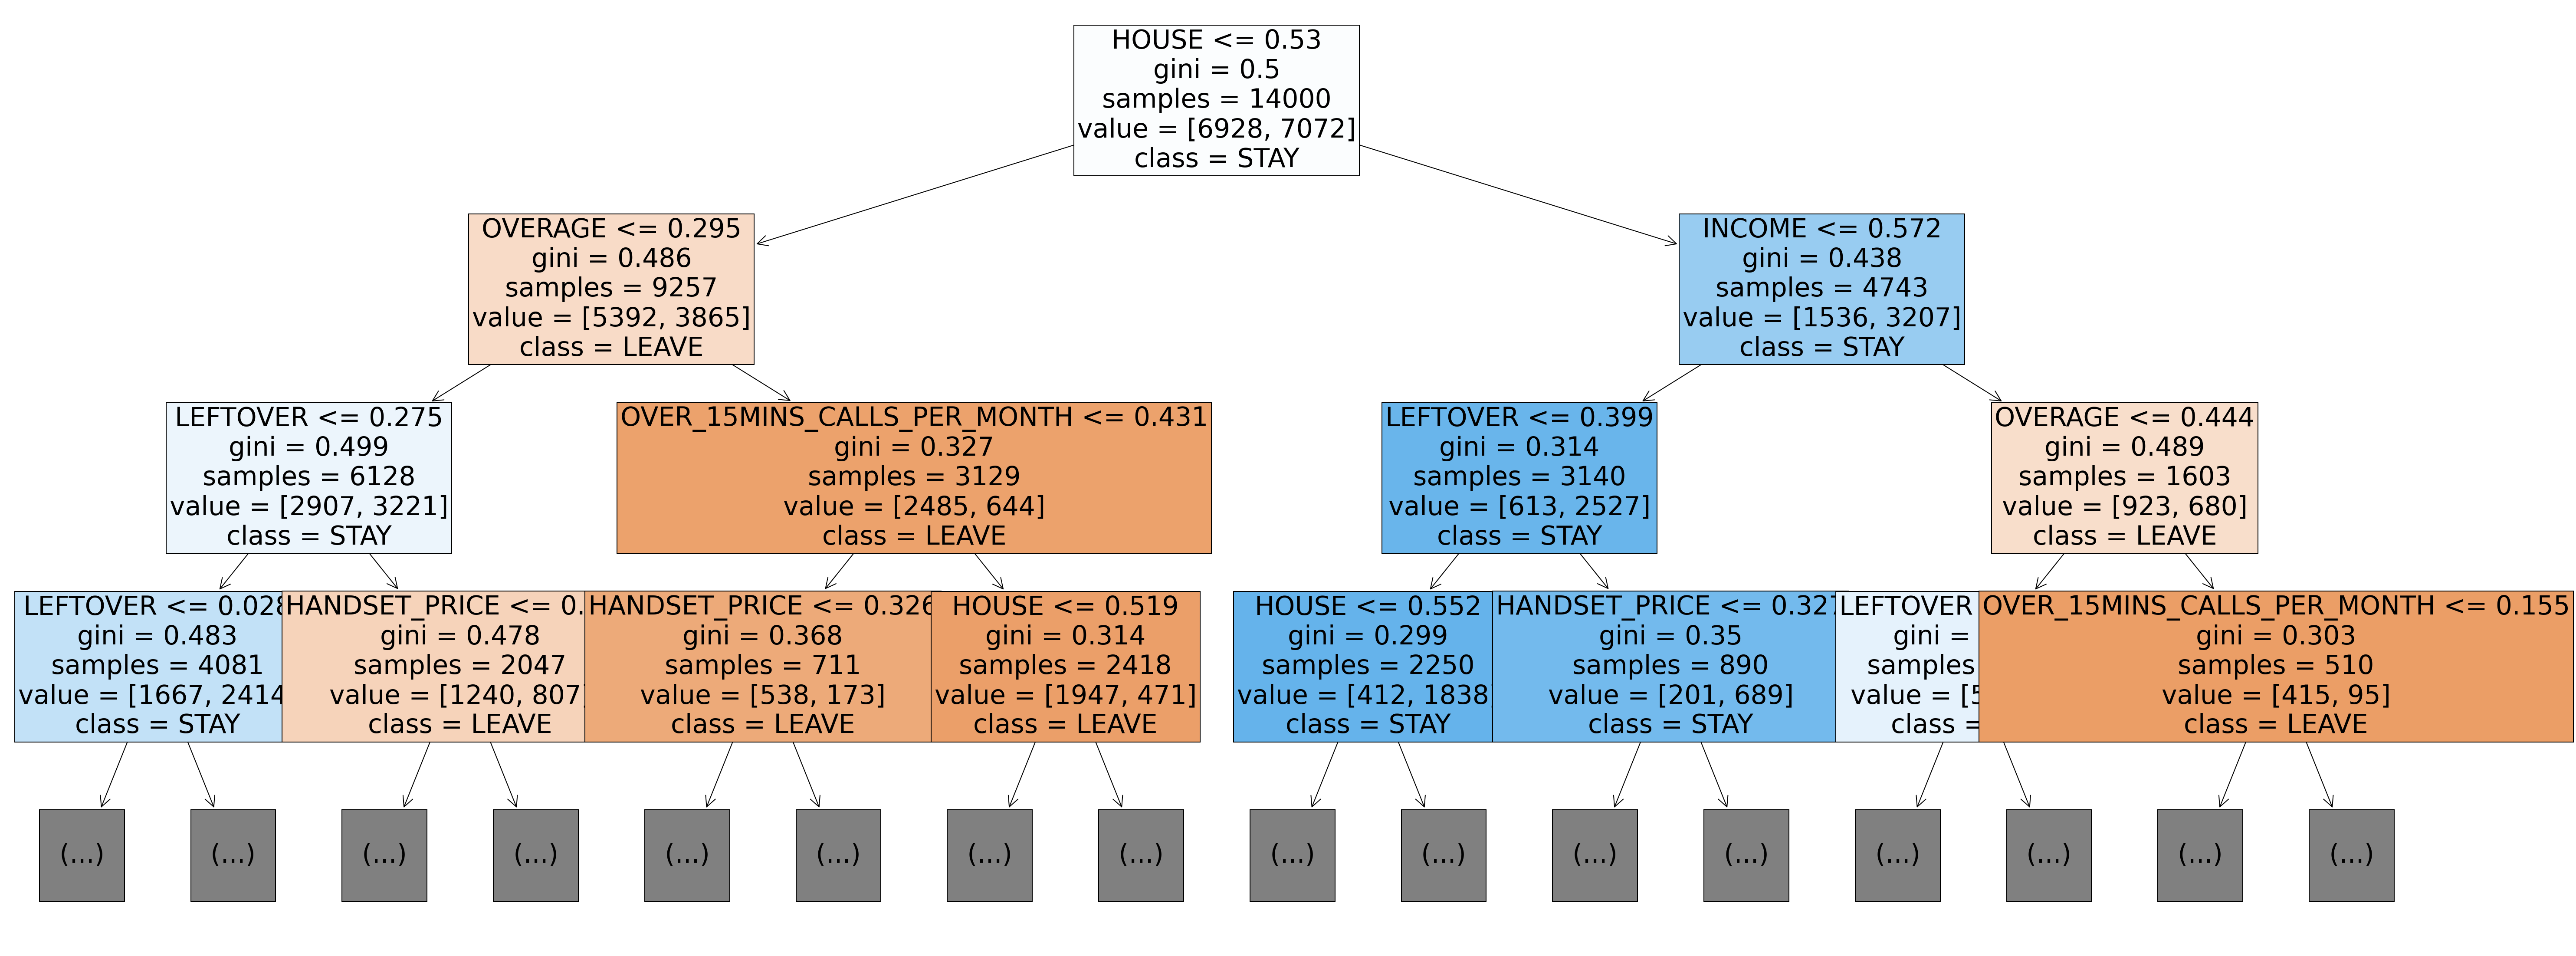

In [37]:
# 트리 시각화
# classname에 leave stay 순서로 작성! 

from sklearn.tree import plot_tree

plt.figure(figsize=(50, 20))
my_tree = plot_tree(dt,
                    feature_names=X.columns,
                    class_names = ['LEAVE','STAY'],
                    fontsize=30,
                    max_depth=3,
                    filled=True)
plt.show()

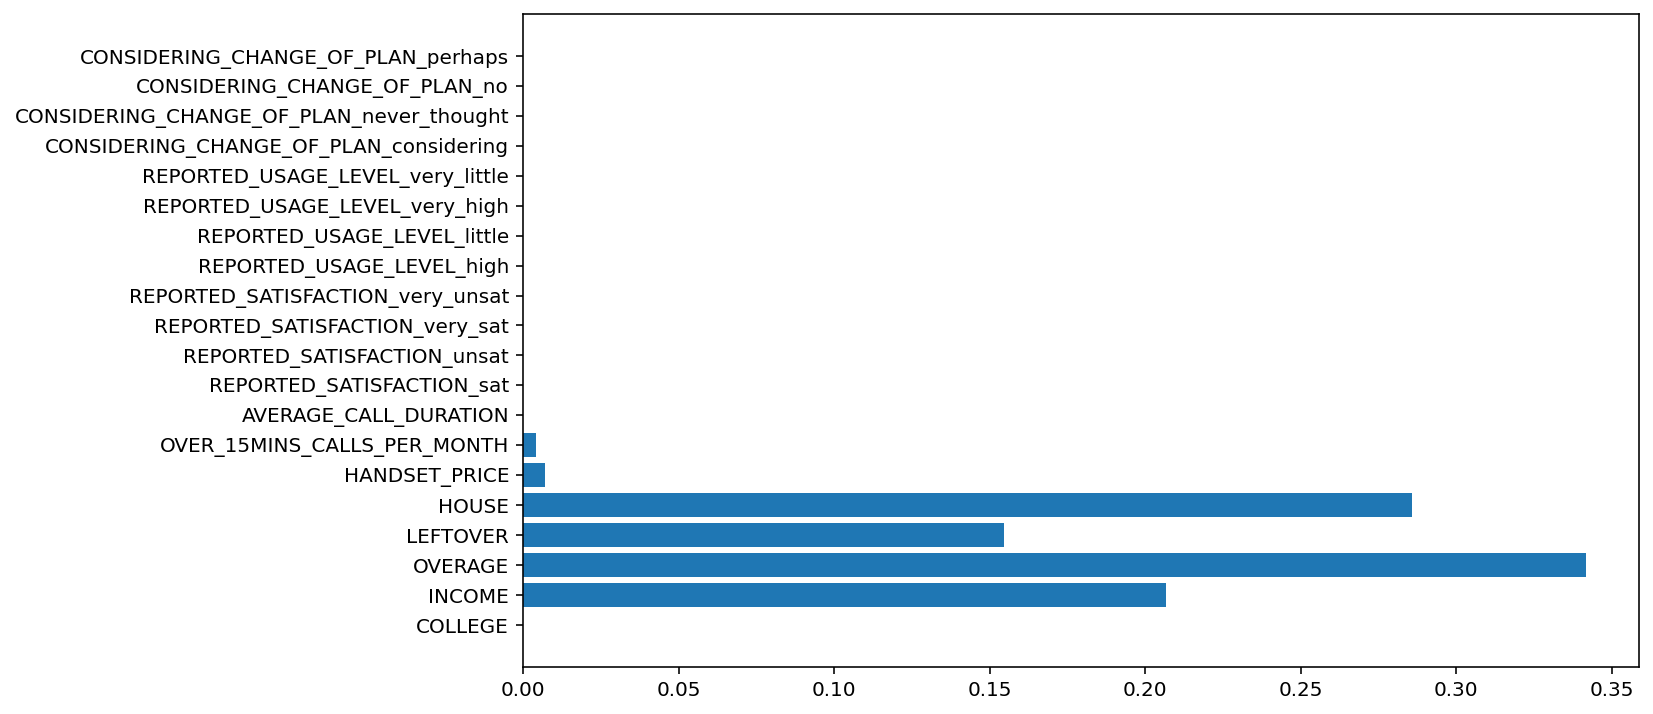

In [36]:
# 변수 중요도 시각화

plt.figure(figsize=(10,6))
plt.barh(list(X), dt.feature_importances_)   # 정보 이득이 높은 피처를 순서대로 확인
plt.show()